## Fast Estimated Effective Migration Surfaces
Analysis of 176 populations of common tansy sampled from across MN.

### Packages and data preparation
Reading in data packages, the data and the digitized global grid (dgg)

In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from cycler import cycler
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"



#Check working directory
import os
os.getcwd()

'/Users/rdbrunquist'

In [3]:
data_path = pkg_resources.resource_filename("feems", "data/")
data_path

'/Users/rdbrunquist/opt/miniconda3/envs/feems_analysis_e/lib/python3.8/site-packages/feems/data/'

In [3]:
# read the genotype data and mean impute missing data 
#The data are in /User/rdbrunquist/opt/minconda3/envs/feems_analysis_e/lib/python3.8/site-packages/feems/data
(bim, fam, G) = read_plink("{}/tansy_plink".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|██████████████████████████████| 3/3 [00:00<00:00, 65.19it/s]

n_samples=178, n_snps=3071


In [4]:
genotypes.shape

(178, 3071)

In [5]:
#remove the two samples from Finland from the array
genotypesMN = np.delete(genotypes, (50,51), axis=0)
genotypesMN.shape

(176, 3071)

### Set-up the graphical space for the FEEMS model

In [6]:
# setup graph
coord = np.loadtxt("{}/tansyMN.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/tansyMNBox.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_area100kmsq.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=1,
                                             outer=outer)

In [7]:
grid.shape

(2109, 2)

### Spatial grid for FEEMS model
Each 176 points are assigned to the closest node in the triangular graph. The triangle grid is a dgg where each triangle is approximately 100 square Km in area. The model will estimate relative resistance to movement along the edges of the triangular grid.

In [8]:
%%time
sp_graph = SpatialGraph(genotypesMN, coord, grid, edges, scale_snps=True)

CPU times: user 8min 2s, sys: 25.1 s, total: 8min 27s
Wall time: 9min 18s


In [9]:
projection = ccrs.PlateCarree(central_longitude=-94)

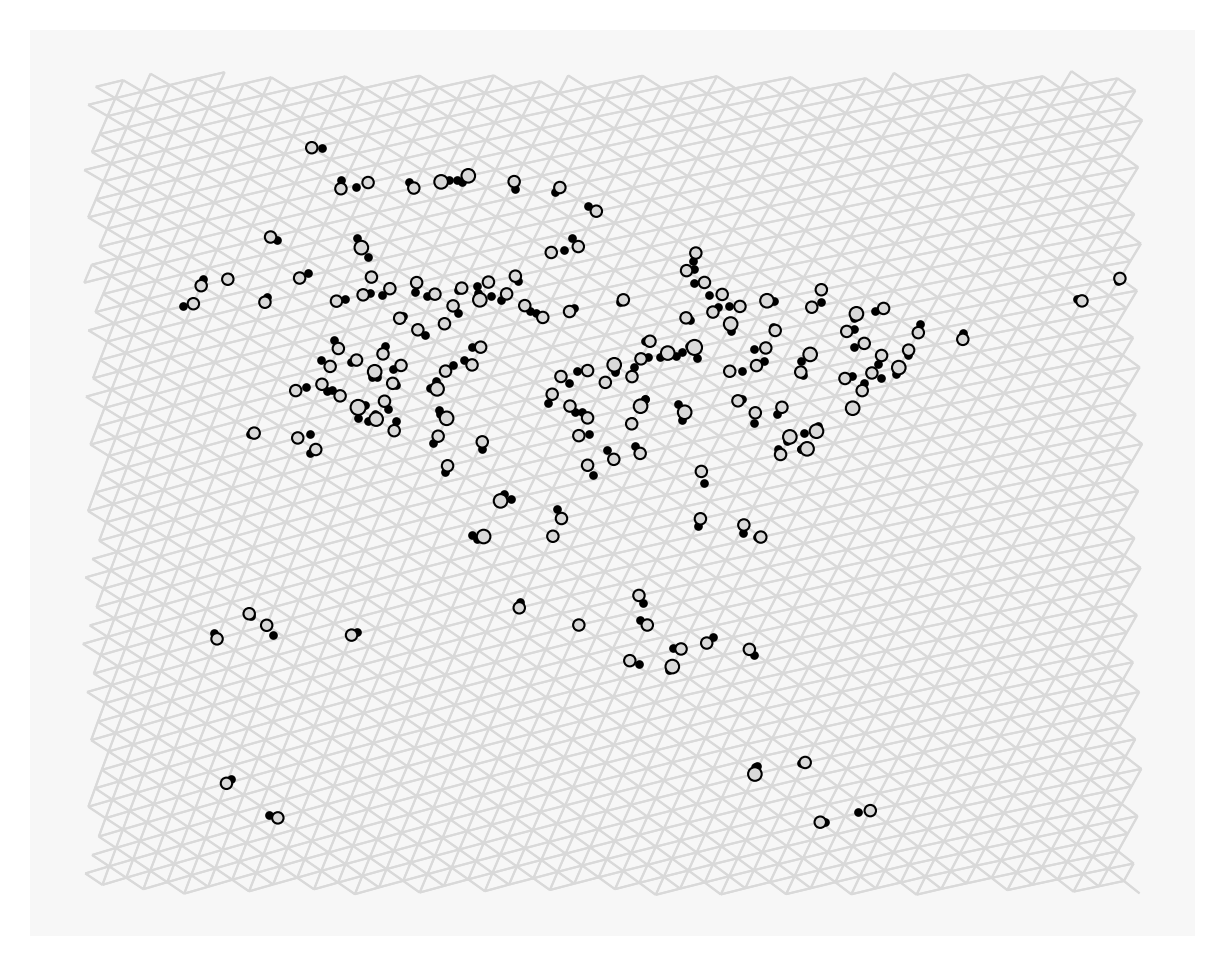

In [10]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [11]:
with PdfPages(r'/Users/rdbrunquist/Desktop/tansy_genomics/feems/figures/feems_popgrid.pdf') as export_pdf:
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
    v.draw_map()
    v.draw_samples()
    v.draw_edges(use_weights=False)
    v.draw_obs_nodes(use_ids=False) 
    export_pdf.savefig()
    plt.close()

#### Model fit with smooth lambda
FEEMS models are parameterized with a smoothing parameter, lambda. Larger values lead to smoother migration surfaces. This model was parameterized with a lambda = 20.

In [12]:
%%time
sp_graph.fit(lamb = 20.0)

constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=20.0000000, alpha=0.2501274, converged in 152 iterations, train_loss=700947.5939053
CPU times: user 20.6 s, sys: 5.31 s, total: 25.9 s
Wall time: 14 s


In [13]:
#If need to see the arguments of the function and what the defaults are for each argument - this is depreceated in python3 but still works with warning
import inspect
#inspect.getargspec(Viz)
#inspect.getargspec(Viz.draw_edges)
#inspect.getargspec(Viz.draw_obs_nodes)
#inspect.getargspec(Viz.draw_edge_colorbar)
#inspect.getargspec(plt.figure)
#inspect.getargspec(plt.rcParams)
print(plt.rcParams["axes.prop_cycle"])

cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


In [14]:
custom_cycler = (cycler(color=['#2ca02c', '#d62728', '#9467bd', '#8c564b']))

plt.rc('axes', prop_cycle=custom_cycler)
print(plt.rcParams["axes.prop_cycle"])

cycler('color', ['#2ca02c', '#d62728', '#9467bd', '#8c564b'])


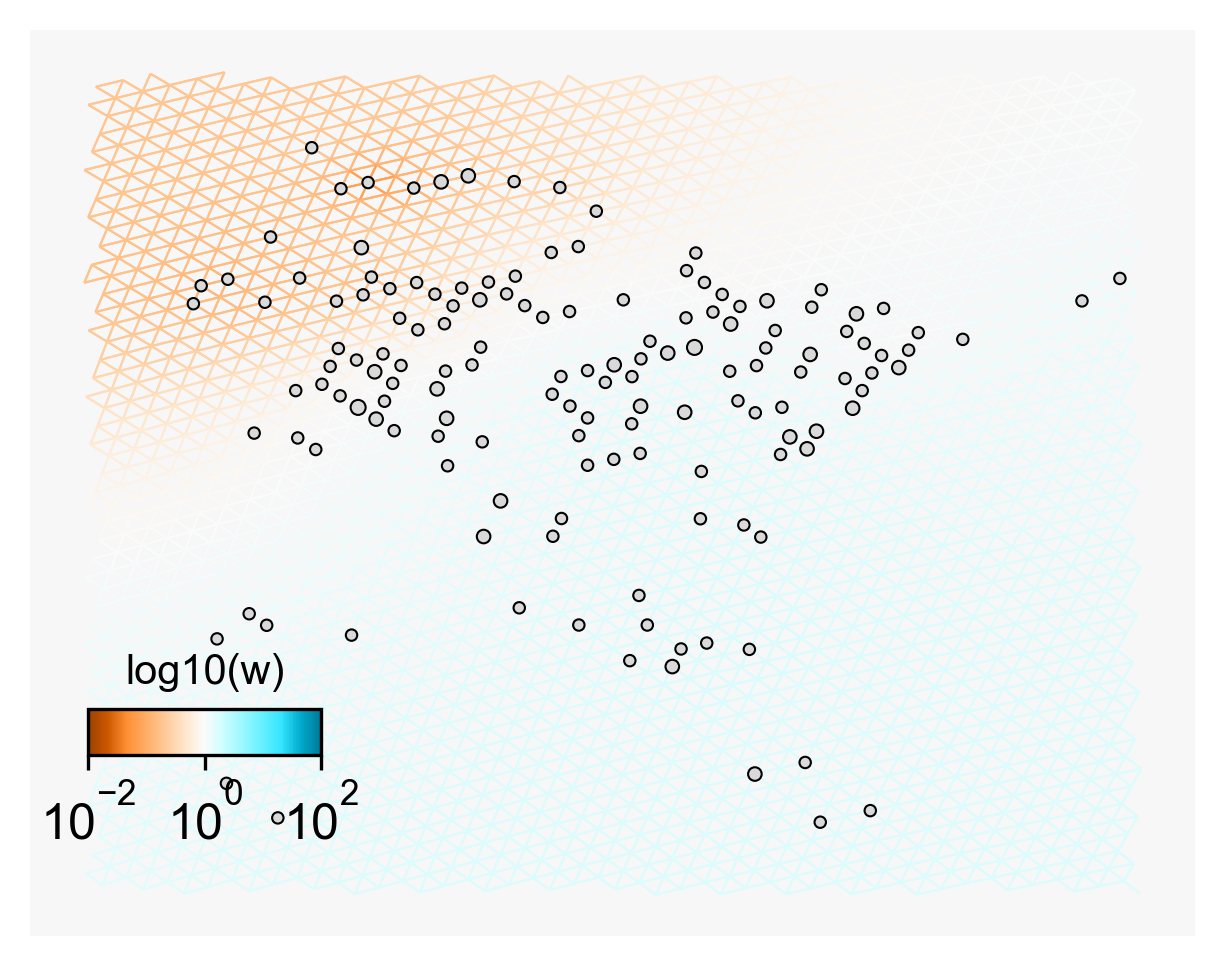

In [15]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection, facecolor = "white")
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

#### Model fit with lambda that allows for greater unevenness in effecive migration
lambda = 2

In [16]:
%%time
sp_graph.fit(lamb = 2.0)

constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=2.0000000, alpha=0.2501274, converged in 157 iterations, train_loss=695599.7308558
CPU times: user 20.7 s, sys: 5.31 s, total: 26 s
Wall time: 13.8 s


In [17]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

## Cross-validation to determine appropriate lambda value
FEEMS suggests using a cross-validation hold-out procedure of each node (n = 146) to determine the most appropriate lambda value for the dataset. The lambda that leads to the lowest L2-cv error is generally considered the most appropriate. We tested 20 logarithmically spaced (e.g. geometric progrssion)lambda values between 0.000001 and 100. 

In [18]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1
 fold= 20
iteration lambda=20/20 alpha=1/1
 fold= 21
iteration lambda=20/20 alpha=1/1
 fold= 22
iteration lambda=20/20 alpha=1/1
 fold= 23
iteration 

## Cross-validation results 
The cv results indicate that lambda = 0.1128 had the lowest cv error and is the most well supported lambda value.

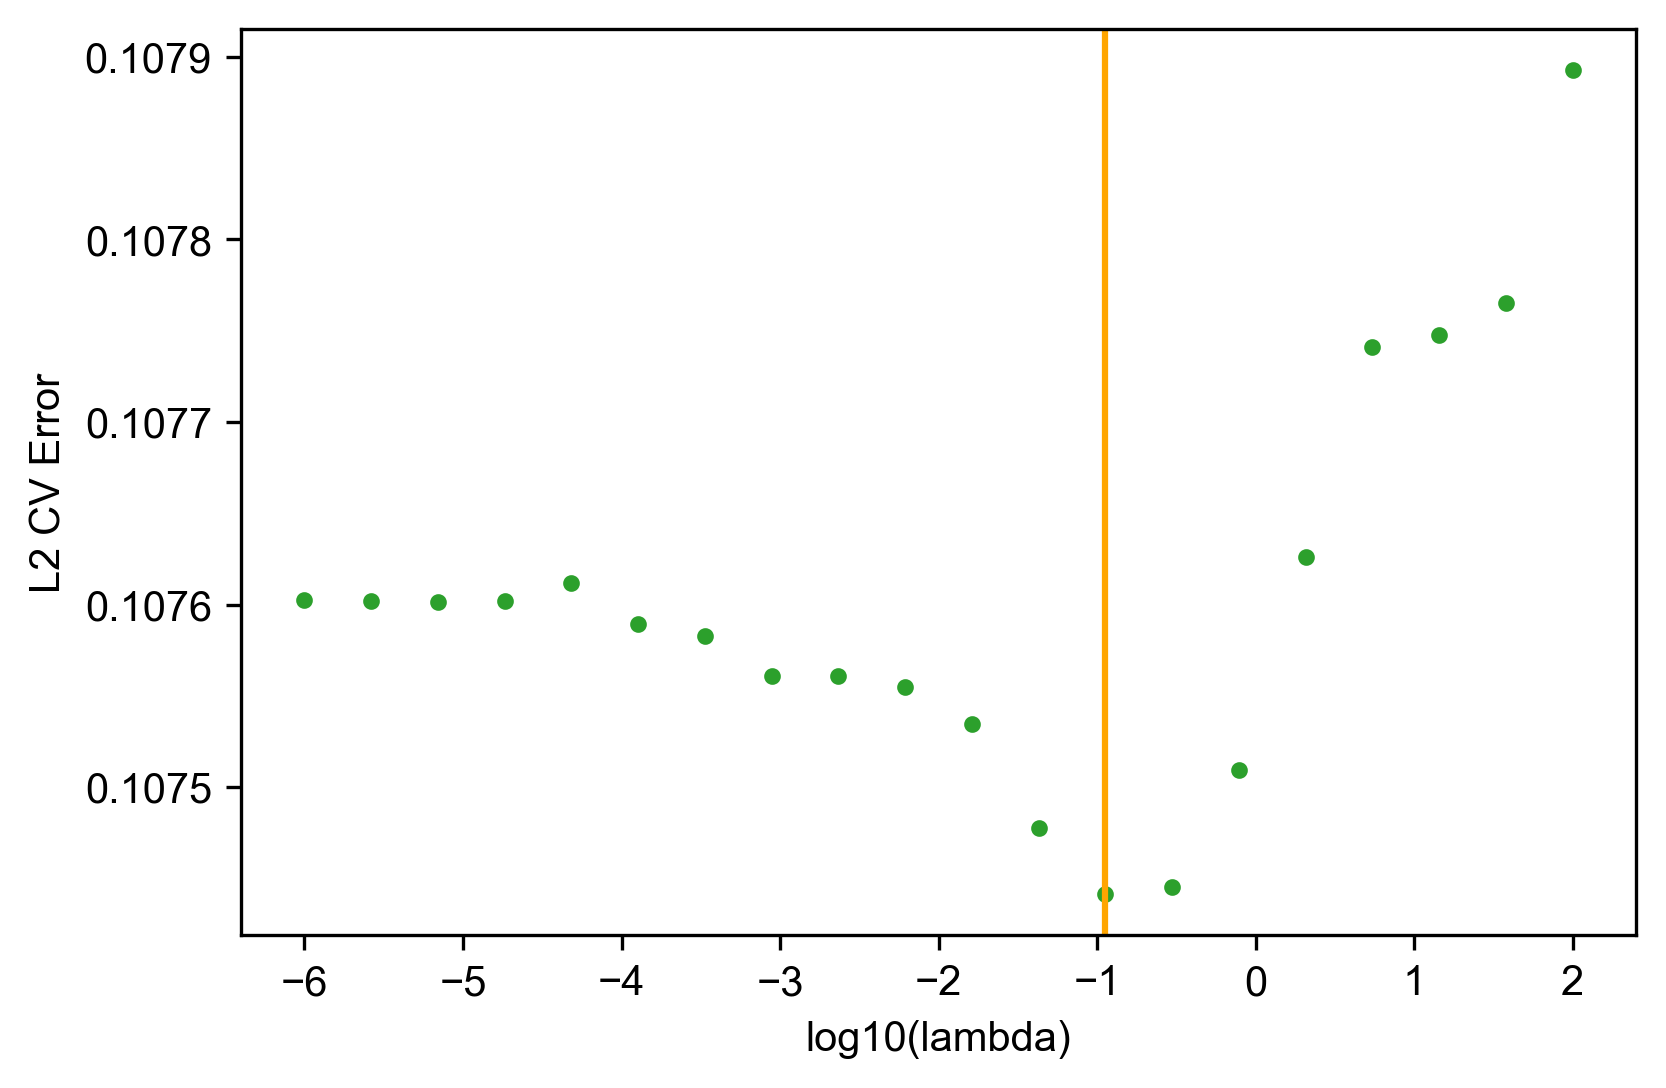

In [19]:
fig, ax = plt.subplots(dpi=300)
ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("L2 CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange")

In [20]:
with PdfPages(r'/Users/rdbrunquist/Desktop/tansy_genomics/feems/figures/feems_cv.pdf') as export_pdf:
    fig, ax = plt.subplots(dpi=300)
    ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
    ax.set_xlabel("log10(lambda)");
    ax.set_ylabel("L2 CV Error");
    ax.axvline(np.log10(lamb_cv), color = "orange")
    export_pdf.savefig()
    plt.close()

## FEEMS maps across multiple lambda values
All values of lambda indicate that there is greater resistance to migration in the NW portions of MN. As lambda decreases this resistance intesifies and there are also pockets in central, northeastern, and southeastern MN that also have reduced effective migaration.

In [21]:
# figure params
projection = ccrs.PlateCarree(central_longitude=-94)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 3
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

# figure setup
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.0, hspace=0.0)

# axis 00 
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[0]))
v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_00.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[0], mean_cv_err[0, 0]), 
           fontdict={"fontsize": 4}, transform = ax_00.transAxes)

# axis 10
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("B", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[3]))
v = Viz(ax_10, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_10.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[3], mean_cv_err[3, 0]), 
           fontdict={"fontsize": 4}, transform = ax_10.transAxes)

# axis 01
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("C", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_cv))
v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_01.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_cv, mean_cv_err[np.argmin(mean_cv_err), 0]), 
           fontdict={"fontsize": 4}, transform = ax_01.transAxes)

# axis 11
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("D", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[10]))
v = Viz(ax_11, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.cbar_font_size = cbar_font_size
v.cbar_orientation = cbar_orientation
v.cbar_ticklabelsize = cbar_ticklabelsize
v.draw_edge_colorbar()
ax_11.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[10], mean_cv_err[10, 0]), 
           fontdict={"fontsize": 4}, transform = ax_11.transAxes)

constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=100.0000000, alpha=0.2501274, converged in 163 iterations, train_loss=702523.4733854
constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=5.4555948, alpha=0.2501274, converged in 150 iterations, train_loss=698107.9902834
constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=0.1128838, alpha=0.2501274, converged in 305 iterations, train_loss=691018.7369056
constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=0.0061585, alpha=0.2501274, converged in 1263 iterations, train_loss=688951.3040279


Text(0.8, 0.85, 'lambda=0.00616\ncv l2 error=0.10756')

In [22]:

# figure params
projection = ccrs.PlateCarree(central_longitude=-94)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 3
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

with PdfPages(r'/Users/rdbrunquist/Desktop/tansy_genomics/feems/figures/feems_four_lambda_panels.pdf') as export_pdf:
    # figure setup
    fig = plt.figure(dpi=300)
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.0, hspace=0.0)

    # axis 00 
    ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
    ax_00.set_title("A", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
    sp_graph.fit(float(lamb_grid[0]))
    v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False) 
    ax_00.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[0], mean_cv_err[0, 0]), 
           fontdict={"fontsize": 4}, transform = ax_00.transAxes)

    # axis 10
    ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
    ax_10.set_title("B", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
    sp_graph.fit(float(lamb_grid[3]))
    v = Viz(ax_10, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False) 
    ax_10.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[3], mean_cv_err[3, 0]), 
           fontdict={"fontsize": 4}, transform = ax_10.transAxes)

    # axis 01
    ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
    ax_01.set_title("C", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
    sp_graph.fit(float(lamb_cv))
    v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False) 
    ax_01.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_cv, mean_cv_err[np.argmin(mean_cv_err), 0]), 
           fontdict={"fontsize": 4}, transform = ax_01.transAxes)

    # axis 11
    ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
    ax_11.set_title("D", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
    sp_graph.fit(float(lamb_grid[10]))
    v = Viz(ax_11, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False)
    v.cbar_font_size = cbar_font_size
    v.cbar_orientation = cbar_orientation
    v.cbar_ticklabelsize = cbar_ticklabelsize
    v.draw_edge_colorbar()
    ax_11.text(.8, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[10], mean_cv_err[10, 0]), 
           fontdict={"fontsize": 4}, transform = ax_11.transAxes)
    export_pdf.savefig()
    plt.close()

constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=100.0000000, alpha=0.2501274, converged in 163 iterations, train_loss=702523.4733854
constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=5.4555948, alpha=0.2501274, converged in 150 iterations, train_loss=698107.9902834
constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=0.1128838, alpha=0.2501274, converged in 305 iterations, train_loss=691018.7369056
constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=0.0061585, alpha=0.2501274, converged in 1263 iterations, train_loss=688951.3040279


## FEEMS map of 'best' lambda
The model using a lambda identified as the most appropriate by cross-validation results in a surface that indicates very low effective migration in the northwest portion of MN with additional pockets of low effective migration in the northeast, central, and southeast.

In [23]:
# re-fit
sp_graph.fit(lamb_cv)

# plot
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=0.1128838, alpha=0.2501274, converged in 305 iterations, train_loss=691018.7369056


In [24]:
# re-fit
sp_graph.fit(lamb_cv)

with PdfPages(r'/Users/rdbrunquist/Desktop/tansy_genomics/feems/figures/feems_best_lambda.pdf') as export_pdf:
    # plot
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False) 
    v.draw_edge_colorbar()
    export_pdf.savefig()
    plt.close()

constant-w/variance fit, converged in 133 iterations, train_loss=702958.8588255
lambda=0.1128838, alpha=0.2501274, converged in 305 iterations, train_loss=691018.7369056
